Cythonize the 2-rounds of MST code

In [1]:
!python setup.py build_ext --inplace

running build_ext
copying build/lib.linux-x86_64-cpython-310/k_mst2.cpython-310-x86_64-linux-gnu.so -> 


Loading required packages and libraries

In [2]:
from sklearn.cluster import KMeans
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import random as rd
import time
import os
from sklearn.metrics import confusion_matrix
from scipy.spatial import distance
from scipy.special import comb
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix, dia_matrix, diags, coo_matrix, lil_matrix
from scipy.optimize import linear_sum_assignment as linear_assignment
import seaborn
import k_mst2


# VI(s)

In [3]:
def _make_cost_m(cm):
  s = np.max(cm)
  # print(-cm, s)
  return (- cm + s)
def clustering_accuracy(clusters, classes):
  cm = confusion_matrix(clusters, classes)
  indexes = linear_assignment(_make_cost_m(cm))
  indexes = np.array(indexes).T
  js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
  cm = cm[:, js]
  return np.trace(cm) / np.sum(cm)

In [4]:
def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

# Colors and markers for visualisation

In [5]:
markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", 4, 5, 6, 7, 8, 9 , 10, 11]
rd.shuffle(markers)
marker_colors = np.random.rand(200,3)

# Proposed clustering algorithm

### Phase I: Determining $O(N^{1/2})$ representatives using partitioning

In [6]:
def bi_means(X, X_indices, max_size, P_dash, C_dash):

    X_partition = X[X_indices]

    if len(X_indices) > max_size:

        X_indices_arr = np.array(X_indices)

        center = X_partition.mean(axis=0)

        distances = distance.cdist([center], X_partition)
        p_index = distances[0].argmax() # farthest point from rep_point

        distances = distance.cdist([X_partition[p_index]], X_partition)
        q_index = distances[0].argmax() # farthest point from p

        distances = distance.cdist(X_partition, [X_partition[p_index], X_partition[q_index]])

        min_i = distances.argmin(axis = 1)

        p_min_Is = np.where(min_i == 0)[0]
        q_min_Is = np.where(min_i == 1)[0]

        bi_means(X, X_indices_arr[p_min_Is], max_size, P_dash, C_dash)
        bi_means(X, X_indices_arr[q_min_Is], max_size, P_dash, C_dash)
    else:
        P_dash.append(X_indices)
        C_dash.append(X_partition.mean(axis=0))

In [7]:
def determine_reps(X, k_dash=10, is_plot=False):

    N, f = X.shape

    P_dash = []
    C_dash = []

    vertices = np.arange(N)

    max_size = k_dash * math.ceil(N ** 0.5)

    bi_means(X, vertices, max_size, P_dash, C_dash)
    C_dash = np.array(C_dash, dtype='float32')

    if is_plot:
        i = 0
        plt.figure(figsize = (7.5, 7.5))
        for Pj in P_dash:
            X_p = X[Pj]
            plt.scatter(X_p[:, 0], X_p[:, 1], color=marker_colors[i % 200], s=60)
            i += 1
        plt.scatter(C_dash[:, 0], C_dash[:, 1], color='C3', marker='*', edgecolor='black', linewidth=1.5, s = 300)
        plt.title("Partitions after stage-1", fontsize=20, fontweight='bold')
        plt.show()

    P = []
    R = []

    for Pj in P_dash:

        X_p = X[Pj]

        Nj = len(Pj)

        n_clusters = k_dash if Nj > k_dash else 2

        if Nj <= n_clusters and Nj > 2:
            n_clusters = 2

        if Nj <= n_clusters:
            P.append( list(Pj) )
            R.append( X_p.mean(axis=0) )
        else:
            temp_P_dash = []
            temp_C_dash = []

            max_size = math.ceil( math.ceil( Nj / n_clusters ) )
            bi_means(X, Pj, max_size, temp_P_dash, temp_C_dash)

            no_clusters = len(temp_C_dash)
            kmeans = KMeans(n_clusters=no_clusters, max_iter=20, n_init=1, init=np.array(temp_C_dash))
            kmeans.fit(X_p)

            labels = kmeans.labels_

            for i in range(no_clusters):
                R.append(kmeans.cluster_centers_[i])
                P.append( Pj[ np.where(labels == i)[0] ] )

    R = np.array(R, dtype='float32')

    if is_plot:
        i = 0
        plt.figure(figsize = (7.5, 7.5))
        for Pj in P:
            X_p = X[Pj]
            plt.scatter(X_p[:, 0], X_p[:, 1], color=marker_colors[i % 200], s=60)
            i += 1
        plt.scatter(R[:, 0], R[:, 1], color='C3', marker='*', edgecolor='black', linewidth=1.5, s = 300)
        plt.title('Final partitions after stage-2', fontsize=20, fontweight='bold')
        plt.show()

    return P, R, P_dash, C_dash

## Phase II: Finding neighbors and two-hops neighbors of representatives using MST

In [8]:
def neighboring_reps(R, num_rounds=2, is_plot=False):
    cen_distances = distance.cdist(R, R).astype('float32')

    n = len(R)
    MST_CEN = []

    us, vs = np.triu_indices(n, 1)
    us = us.astype('int32')
    vs = vs.astype('int32')
    ws = cen_distances[us, vs]
    sorted_ws = np.argsort(ws)
    vertices = np.arange(n, dtype=int).tolist()

    for _ite in range(num_rounds):

        parent = np.arange(n, dtype='int32')
        rank = np.zeros(n, dtype='int32')
        _MST_CEN = np.zeros(( n - 1, 3 ), dtype='float32')
        k_mst2.k_mst(_ite, sorted_ws, us, vs, ws, parent, rank, _MST_CEN, n)

        MST_CEN += _MST_CEN.tolist()

    neighbors = [[i] for i in range(n)]
    for edge in MST_CEN:
        u, v, w = edge
        u, v = int(u), int(v)
        neighbors[u].append(v)
        neighbors[v].append(u)

    neighbors_arr = np.array(neighbors, dtype='object')

    if is_plot:
        plt.figure(figsize = (7.5, 7.5))
        plt.scatter(R[:, 0], R[:, 1], color='C3', marker='*', edgecolor='black', linewidth=1.5, s = 400, zorder=1)

        for edge in MST_CEN:
            u, v, w = edge
            u, v = int(u), int(v)
            (x1, y1), (x2, y2) = R[u], R[v]
            plt.plot( (x1, x2),  (y1, y2), c='black', linewidth=5, zorder=0)

        plt.title('Neighboring representatives', fontsize=20, fontweight='bold')
        plt.show()

    return MST_CEN, neighbors_arr


## Phase III: Approximate searching to construct the bipartite proximity graph

In [9]:
def build_bip_graph(X, K, P, R, is_plot=False):
    ti = time.process_time()

    M2, NN = neighboring_reps(R, is_plot=is_plot)

    N = len(X)
    p = len(R)
    A = lil_matrix((N, p), dtype='float32')

    for i in range(p):

        X_i = np.array(P[i])

        NN2 = np.array( list( set( sum( NN[ NN[i] ], [] ) ) ) )

        dists = distance.cdist(X[X_i], R[NN2])

        r = len( NN[i] ) - 1

        dists_sorted = dists.argsort(axis=1)

        r_dists = dists_sorted[:, :r]
        nr = r_dists.shape[1]
        nn = len(X_i)
        U = np.array(np.arange(nn).tolist() * nr).reshape(nr, nn).T.flatten().tolist()
        V = r_dists.flatten().tolist()

        s1 = dists[U, V].flatten()
        A[X_i[U], NN2[V]] = s1

    if is_plot:
        A1 = coo_matrix(A, dtype='float32')
        plt.figure(figsize=(7.5, 7.5))
        plt.scatter(X[:,0], X[:,1], s=50, c='C0', edgecolor='black', linewidth=1, zorder=1)
        plt.scatter(R[:, 0], R[:, 1], color='C3', marker='*', edgecolor='black', linewidth=1.5, s = 300)
        for i, j, d in zip(A1.row, A1.col, A1.data):
            (x1, y1),(x2, y2) = X[i], R[j]
            plt.plot((x1, x2), (y1, y2), c='black', zorder=0)

        plt.title( 'Proposed bipartite graph' )
        plt.show()

    A = csr_matrix(A, dtype='float32')

    h = A.data.mean()
    # print(p, h)
    np.exp((- A.power(2) / (2 * h ** 2)).data, out = A.data)

    return A

## Phase IV: Eigenvectors projection using Tcuts and Lancsoz method

In [10]:
def t_cut_fast(W, K, noise=1e-10, is_plot=False):

    if noise > 1e-10: W.data = W.data + noise

    N, p = W.shape

    dx = np.sum(W, 1, dtype='float32')
    dx = 1 / (dx + noise)

    Dx = diags(np.array(dx, dtype='float32').reshape(N))

    Wr = ( W.T @ Dx @  W )

    dx = np.sum(Wr, 1, dtype='float32') + noise

    Dr = diags(np.array(dx, dtype='float32').reshape(p))

    Dr_inv_sqrt = dia_matrix( Dr )
    Dr_inv_sqrt.data = 1 / (Dr_inv_sqrt.data ** 0.5)

    L_sym = Dr_inv_sqrt @ ( Dr - Wr ) @ Dr_inv_sqrt

    vals, vecs = eigsh(L_sym, k=K, which='SM')
    Ncut_avec = Dr_inv_sqrt @ vecs

    del dx, Wr

    res = Dx @ W @ Ncut_avec
    res = np.nan_to_num(res)

    res = res / np.reshape(np.linalg.norm(res, axis=1) + 1e-10, (res.shape[0], 1))

    if is_plot:
        plt.figure(figsize=(7.5, 7.5))
        seaborn.heatmap(res, cbar=False)

        for i in range(1, K):
            plt.plot((i, i), (0, N - 1), linewidth=5, c='C0')

        plt.title('Eigenvector projection')
        plt.show()

    return res

## Phase V: Post-clustering using $K$-means

In [11]:
def k_means(data, K, max_iter=15):

    max_ca = 0
    best_labels = None

    for iter in range(15):

        kmeans = KMeans(n_clusters=K, init='random', n_init=1)
        kmeans.fit(data)

        labels = kmeans.labels_

        ca = clustering_accuracy(lab, labels)

        if ca > max_ca:
            best_labels = labels
            max_ca = ca

    return max_ca, best_labels

## SBSC algorithm

In [12]:
def sbsc(X, K, k_dash=10, noise=1e-10, num_iter=10, is_plot=False, verbose=0, ds_name='undefined', target_path='/'):

    N, f = X.shape

    labels_all = []
    CA_all = []
    RI_all = []

    bt = time.process_time()

    P, R, P_dash, C_dash = determine_reps(X, k_dash=k_dash, is_plot=is_plot)

    W = build_bip_graph(X, K, P, R, is_plot=is_plot)

    nnz = len(W.nonzero()[0])

    t1 = time.process_time() - bt

    bt = time.process_time()

    if verbose > 0: print( 'CA for each iteration: ', end='\t' )

    for iter in range(num_iter):

        if iter == 0:
            res = t_cut_fast(W, K, noise=noise, is_plot=is_plot)
        else:
            res = t_cut_fast(W, K, noise=noise, is_plot=False)

        max_ca, max_labels = k_means(res.real, K)

        labels_all.append(max_labels.tolist())

        CA_all.append(max_ca)

        RI_all.append(rand_index_score(lab, max_labels))

        if verbose > 0: print( round( max_ca, 4 ), end='\t' )

    t2 = (time.process_time() - bt) / num_iter


    avg_ca = np.mean(CA_all)
    print("\n\nAvg. CA: ", avg_ca)

    avg_ri = np.mean(RI_all)
    print("\nAvg. RI: ", avg_ri)

    print("\nAvg. running time (sec): ", t1 + t2)

    max_labels = labels_all[ np.argmax(CA_all) ]
    labels_arr = np.array(labels_all).T
    max_ca = max(CA_all)

    if verbose > 1:

        df1 = pd.DataFrame(labels_arr)
        df1.to_csv(target_path + "/sbsc-pred-labels-" + ds_name[:-4] + ".csv", sep=",", header=None, index=None)

    if is_plot:
        plt.figure(plt.figure(figsize=(7.5, 7.5)))
        plt.scatter(X[:,0], X[:,1], c=max_labels, s=50)
        plt.title('Final clusters with CA: ' + str(round(max_ca, 4)))
        plt.show()

    return max_ca, labels_arr

# Test

## Loading a dataset

(20000, 2) 4


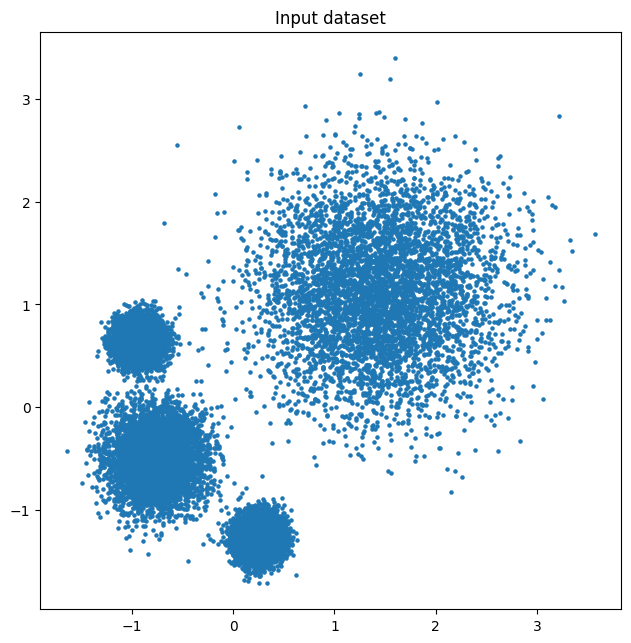

In [13]:
base_path = '' # path of the directory in which dataset is present
target_path = '' # path of the directory to save the results

filename, sep = "temp-varied-2.txt", "\t"

# loading the dataset
df = pd.read_csv(base_path + filename, sep=sep, header=None)
df, lab = df.iloc[:, :-1], df.iloc[:, -1].astype('int')

# K is the number of clusters, N is the number of data points, and f is the number of features
K = len(set(lab))
X = np.array(df, dtype='float32')
print(X.shape, K)

N, f = X.shape

if f == 2:
    plt.figure(plt.figure(figsize=(7.5, 7.5)))
    plt.scatter(X[:,0], X[:,1], color='C0', s=5)
    plt.title( 'Input dataset' )
    plt.show()

del df

## Clustering using SBSC for a synthetic dataset along with the visualization

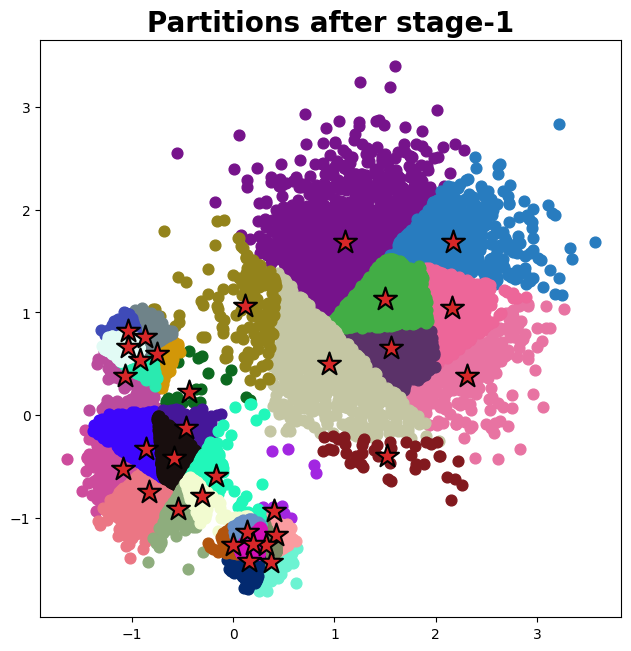

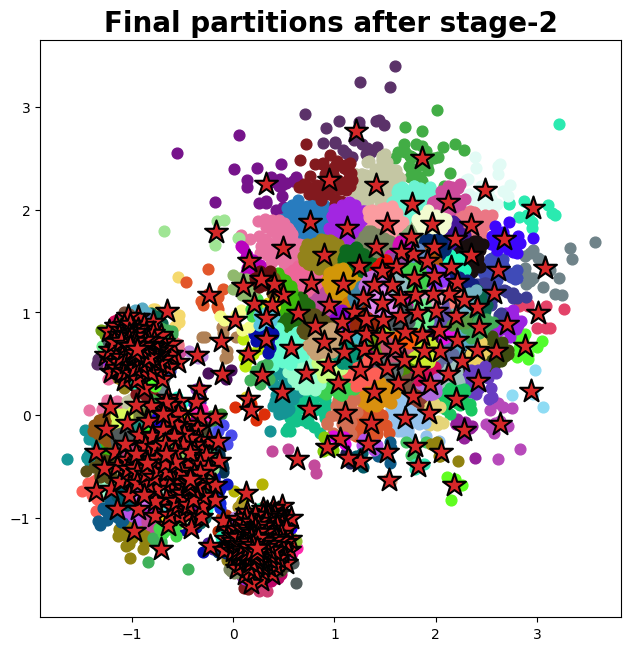

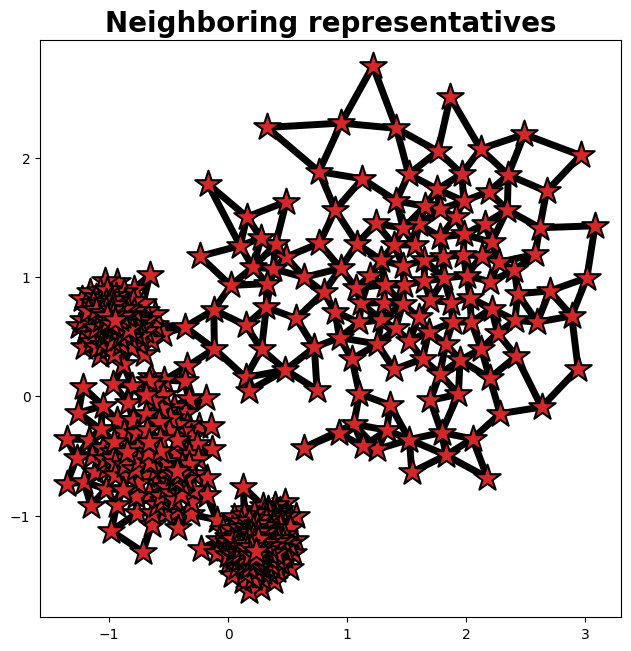

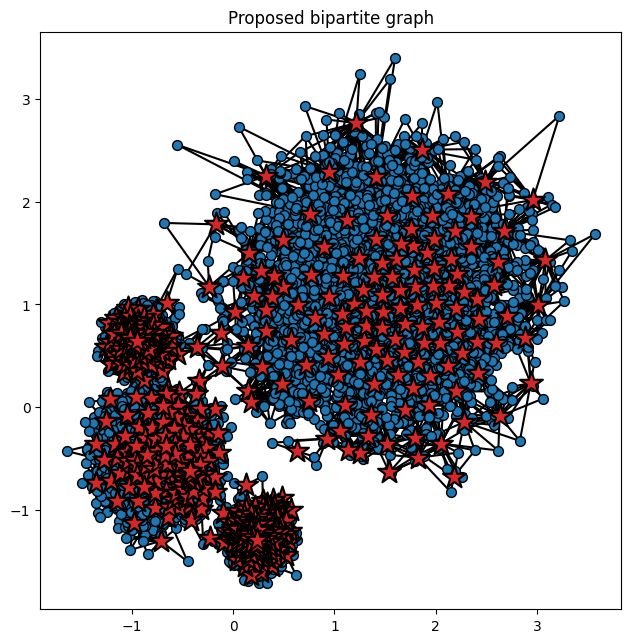

CA for each iteration: 	

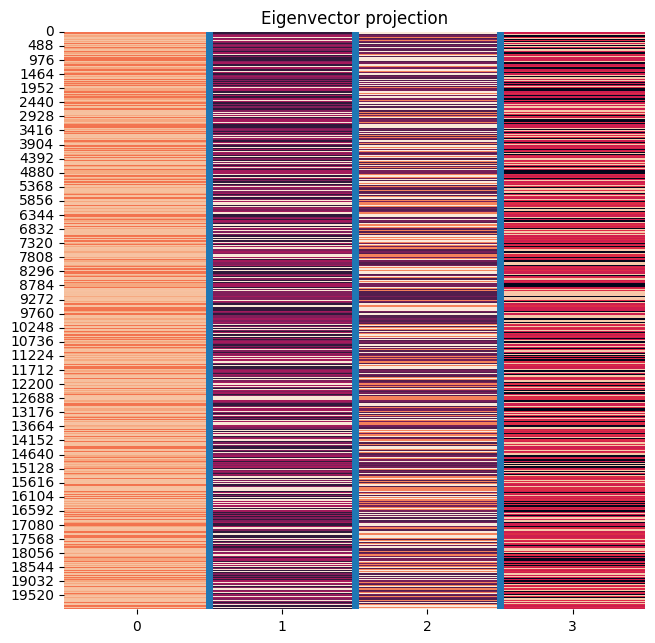

0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	

Avg. CA:  0.999

Avg. RI:  0.9990007150357518

Avg. running time (sec):  102.9980933894


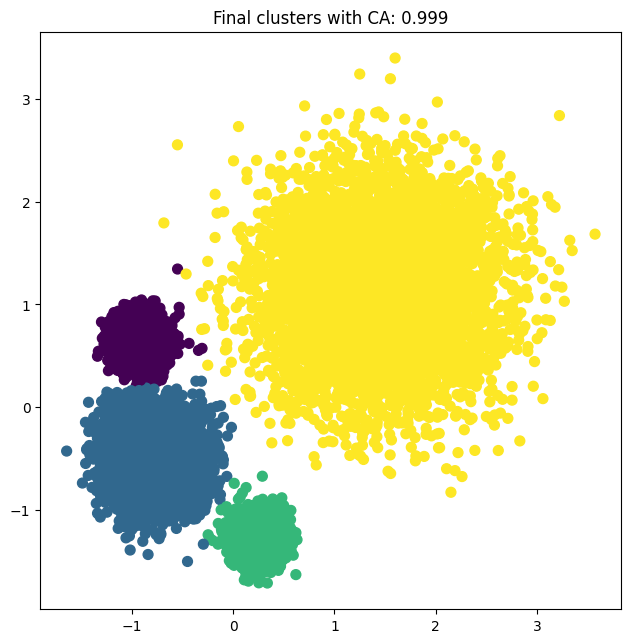

In [14]:
# set verbose=2 to save the results

CA, pred_labels = sbsc( X, K, noise=1e-10, num_iter=10, is_plot=True,
                        verbose=1, ds_name=filename, target_path=target_path )

# Note: if dataset is massive then the visualization part is time consuming

## Clustering without visualization

In [15]:
CA, pred_labels = sbsc( X, K, num_iter=10, is_plot=False,
                        verbose=1, ds_name=filename, target_path=target_path )

CA for each iteration: 	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	

Avg. CA:  0.999

Avg. RI:  0.9990007150357518

Avg. running time (sec):  0.6353225992000049
